In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
---

In [12]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(dataset: EpisodeDataset, batch_size: int, repeats: int):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        repeats=repeats,
    )
    print(f"batch_repeat_sampler: {list(batch_repeat_sampler)}")

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    repeats=config.episode_steps,
)

train_dataset : 100
test_dataset : 2000
eval_dataset : 100
batch_repeat_sampler: [66, 9, 0, 24, 79, 61, 95, 13, 8, 77, 46, 6, 88, 56, 89, 86, 65, 98, 60, 10, 37, 26, 84, 5, 42, 64, 83, 15, 94, 78, 49, 51, 25, 11, 30, 50, 43, 2, 69, 23, 36, 44, 27, 58, 92, 80, 81, 97, 68, 90, 66, 9, 0, 24, 79, 61, 95, 13, 8, 77, 46, 6, 88, 56, 89, 86, 65, 98, 60, 10, 37, 26, 84, 5, 42, 64, 83, 15, 94, 78, 49, 51, 25, 11, 30, 50, 43, 2, 69, 23, 36, 44, 27, 58, 92, 80, 81, 97, 68, 90, 66, 9, 0, 24, 79, 61, 95, 13, 8, 77, 46, 6, 88, 56, 89, 86, 65, 98, 60, 10, 37, 26, 84, 5, 42, 64, 83, 15, 94, 78, 49, 51, 25, 11, 30, 50, 43, 2, 69, 23, 36, 44, 27, 58, 92, 80, 81, 97, 68, 90, 66, 9, 0, 24, 79, 61, 95, 13, 8, 77, 46, 6, 88, 56, 89, 86, 65, 98, 60, 10, 37, 26, 84, 5, 42, 64, 83, 15, 94, 78, 49, 51, 25, 11, 30, 50, 43, 2, 69, 23, 36, 44, 27, 58, 92, 80, 81, 97, 68, 90, 66, 9, 0, 24, 79, 61, 95, 13, 8, 77, 46, 6, 88, 56, 89, 86, 65, 98, 60, 10, 37, 26, 84, 5, 42, 64, 83, 15, 94, 78, 49, 51, 25, 11, 30, 50, 43,

fov: torch.Size([11, 11])


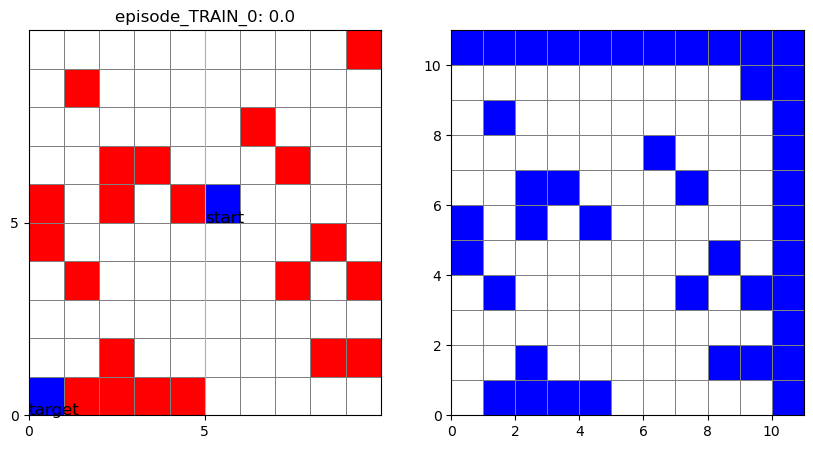

In [13]:
episode1 = train_dataset.episodes[0]

# Viz world
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
episode1.viz(ax=axes[0], reward_model=reward_model)

# Viz fov
fov = episode1.world.fov(center_pos=episode1.agent.start_state.position())
print(f"fov: {fov.size()}")
# print(f"fov: {fov}")
episode1.world.viz_fov(center_pos=episode1.agent.start_state.position(), ax=axes[1])
plt.show()

In [14]:
def train_and_plot_policy(policy: Policy, debug: bool = False):
    episode = Episode.new(id="train")
    print(f"start: {episode.agent.current_state}")
    episode.train(steps=20, policy=policy, debug=debug)
    print(f"start2: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, reward_model=reward_model, color=get_color(0))
    plt.show()

    return episode


def inference_and_plot_policy(policy: Policy, steps: int = 20, debug: bool = False):
    episode = Episode.new(id="inference")
    # print(f"start state: {episode.agent.start_state}")
    # print(f"target state: {episode.agent.target_state}")
    episode.inference_steps_by_policy(steps=steps, policy=policy, debug=debug)
    # print(f"end state: {episode.agent.current_state}")

    fig = plt.figure(figsize=config.figure_size)
    ax = fig.add_subplot(1, 1, 1)
    episode.viz(ax=ax, reward_model=reward_model, color=get_color(0))
    plt.show()

    return episode

step: 0, logits: tensor([[ 0.0411, -0.4848, -1.3840, -0.7214, -0.0239,  0.7325, -0.9992, -0.9262,
          1.1819]]), logit_prob: tensor([[0.1873]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([6, 6]), action_history: [tensor(8)]
step: 1, logits: tensor([[ 0.4340,  0.2308, -1.3164, -1.0585,  1.3316,  1.2176, -1.6110, -1.1113,
          2.9726]]), logit_prob: tensor([[0.1964]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([7, 7]), action_history: [tensor(8), tensor(8)]
step: 2, logits: tensor([[ 0.2373, -0.1357, -1.0630, -1.3151,  1.0366,  1.8920, -0.9901, -1.5898,
          3.4310]]), logit_prob: tensor([[0.2017]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([8, 8]), action_history: [tensor(8), tensor(8), tensor(8)]
step: 3, logits: tensor([[ 0.6505,  0.3305, -0.6608, -1.8022,  1.1333,  1.0571, -1.1555, -0.0462,
          4.2634]]), logit_prob: tensor([[0.2011]]), top_k_prob: tensor([[1.]]), action_idx: tenso

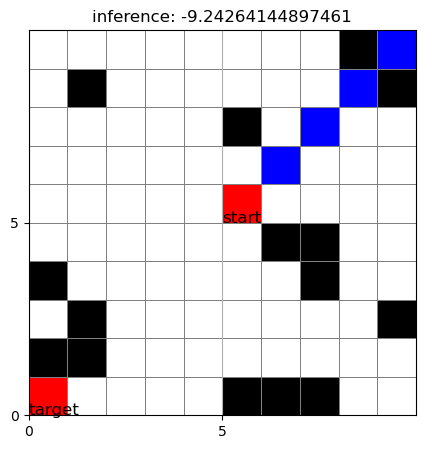

In [15]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)
# episode.agent.action_history

# Training Loop
---

In [16]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[ 0.1066, -0.6030, -1.0179, -1.5010,  0.6030,  0.1084, -0.6625, -1.6646,
          1.7734]]), logit_prob: tensor([[0.1948]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([6, 6]), action_history: [tensor(8)]
step: 1, logits: tensor([[ 0.9189, -0.5683, -1.5855, -0.8825,  1.0820,  1.3564, -1.1592, -0.4618,
          2.7365]]), logit_prob: tensor([[0.1918]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([7, 7]), action_history: [tensor(8), tensor(8)]
step: 2, logits: tensor([[ 0.4568,  0.2817, -2.0142, -2.0000,  1.4692,  0.8597, -0.6973, -0.7695,
          3.1981]]), logit_prob: tensor([[0.1924]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[8]]), state: tensor([8, 8]), action_history: [tensor(8), tensor(8), tensor(8)]
step: 3, logits: tensor([[ 0.2276, -0.3646, -1.0357, -1.1119,  0.4650,  1.0410, -0.9961, -0.7579,
          3.6448]]), logit_prob: tensor([[0.2210]]), top_k_prob: tensor([[1.]]), action_idx: tenso

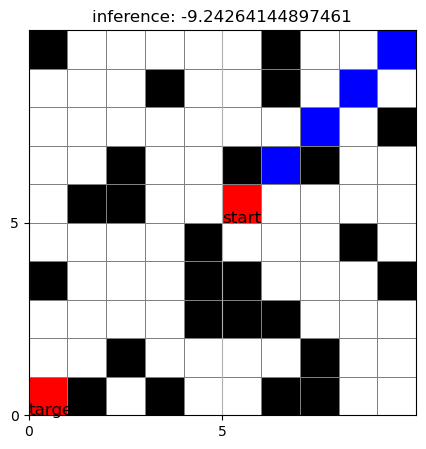

In [17]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(policy=test_policy, steps=5, debug=True)

In [18]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
# plt.ion()

batch_repeat_sampler: [96, 38, 97, 70, 6, 64, 67, 27, 95, 86, 14, 88, 32, 29, 75, 98, 99, 30, 47, 22, 7, 24, 35, 12, 73, 0, 71, 34, 76, 69, 18, 52, 50, 57, 46, 89, 13, 45, 81, 2, 16, 72, 37, 85, 11, 62, 79, 15, 53, 19, 96, 38, 97, 70, 6, 64, 67, 27, 95, 86, 14, 88, 32, 29, 75, 98, 99, 30, 47, 22, 7, 24, 35, 12, 73, 0, 71, 34, 76, 69, 18, 52, 50, 57, 46, 89, 13, 45, 81, 2, 16, 72, 37, 85, 11, 62, 79, 15, 53, 19, 96, 38, 97, 70, 6, 64, 67, 27, 95, 86, 14, 88, 32, 29, 75, 98, 99, 30, 47, 22, 7, 24, 35, 12, 73, 0, 71, 34, 76, 69, 18, 52, 50, 57, 46, 89, 13, 45, 81, 2, 16, 72, 37, 85, 11, 62, 79, 15, 53, 19, 96, 38, 97, 70, 6, 64, 67, 27, 95, 86, 14, 88, 32, 29, 75, 98, 99, 30, 47, 22, 7, 24, 35, 12, 73, 0, 71, 34, 76, 69, 18, 52, 50, 57, 46, 89, 13, 45, 81, 2, 16, 72, 37, 85, 11, 62, 79, 15, 53, 19, 96, 38, 97, 70, 6, 64, 67, 27, 95, 86, 14, 88, 32, 29, 75, 98, 99, 30, 47, 22, 7, 24, 35, 12, 73, 0, 71, 34, 76, 69, 18, 52, 50, 57, 46, 89, 13, 45, 81, 2, 16, 72, 37, 85, 11, 62, 79, 15, 53, 1

/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())
/Users/chengbai/ml/cheng_git/rf_agent/src/reward_model.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dxy = torch.tensor(action.get_udpate())


step: 0, logits: tensor([[ 4.6292e+09, -1.8277e+09, -2.8556e+09,  4.4745e+09, -4.9912e+09,
         -2.6941e+09,  4.6456e+09, -5.7800e+08,  4.4428e+09]]), logit_prob: tensor([[0.1576]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([6, 4]), action_history: [tensor(6)]
step: 1, logits: tensor([[ 5.1619e+09, -2.0530e+09, -3.1968e+09,  4.9839e+09, -5.5803e+09,
         -2.9908e+09,  5.1790e+09, -6.1780e+08,  4.9778e+09]]), logit_prob: tensor([[0.1575]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([7, 3]), action_history: [tensor(6), tensor(6)]
step: 2, logits: tensor([[ 6.0249e+09, -2.4029e+09, -3.7334e+09,  5.8233e+09, -6.5264e+09,
         -3.4788e+09,  6.0514e+09, -7.1058e+08,  5.8174e+09]]), logit_prob: tensor([[0.1574]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[6]]), state: tensor([8, 2]), action_history: [tensor(6), tensor(6), tensor(6)]
step: 3, logits: tensor([[ 6.8057e+09, -2.7150e+09, -4.2229e+09,  6.5789e+09, -7.3576e+0

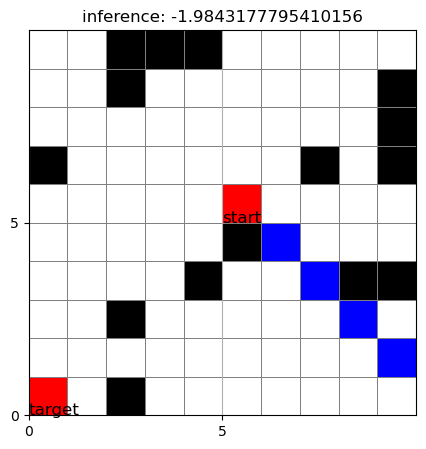

episode reward: -1.9843177795410156


In [21]:
episode = inference_and_plot_policy(
    policy=policy, steps=config.episode_steps, debug=True
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")